**WARNING:**

This is my first ML project.

I'm not so sure if what I did was *correct* but the approach of this notebook worked on real life and solved my problem.

## Setup & Imports
If Tensorflow Graphics is not installed on your system, the following cell can install the Tensorflow Graphics package for you.

In [0]:
!pip install tensorflow_graphics

Now that Tensorflow Graphics is installed, let's import everything needed to run the demos contained in this notebook.

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_graphics as tfg
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_graphics.geometry.transformation import quaternion
from tensorflow_graphics.math import vector
from tensorflow_graphics.notebooks import threejs_visualization
from tensorflow_graphics.notebooks.resources import tfg_simplified_logo


import sys
module = sys.modules['tensorflow_graphics.util.shape']
def _get_dim(tensor, axis):
  """Returns dimensionality of a tensor for a given axis."""
  return tf.compat.v1.dimension_value(tensor.shape[axis])

module._get_dim = _get_dim

sys.modules['tensorflow_graphics.util.shape'] = module

# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Now lets define our 3D points for data generation.
Faces are used only for debugging so don't worry about it.

In [0]:
vertices = np.array(
       [
    #nose tip
   [ 0.0,
    1 * 0.003874,
    1 * 0.290468,],

    # bottom nose
   [ 0.0,
    1 * -1.26207,
    1 * -1.14108],

    # left nostril
  [  -0.85877,
    1 * -1.05017,
   1 * -1.53035],

    # right nostril
  [  0.85877,
    1 * -1.05017,
    1 * -1.53035],

    # left eye leftcorner
    [-4.49893,
    1 * 3.21601,
    1 * -4.22082],

    # left eye right corner
   [ -1.9326,
    1 * 3.14086,
    1 * -3.78216],

    # right eye right corner
  [  4.49893,
    1 * 3.21601,
    1 * -4.22082],

    # right eye left corner
  [  1.9326,
    1 * 3.14086,
    1 * -3.78216],

    # left mouth corner
   [ -2.17298,
    1 * -3.62696,
    1 * -3.15651],
    # right mouth corner
  [  2.17298,
    1 * -3.62696,
    1 * -3.15651],
    ],
    dtype="float32"
  )
faces = np.array([
  [2,1,0],
  [1,3,0],
  [6,7,0],
  [5,4,0],
  [8,9,1]
],dtype="float32")
num_vertices = vertices.shape[0]

# Data generation and pre-processing

We project the 3d points onto a 2D plane.
An approximated focal point and projection centeris used and it won't interfere too much with results.

In [0]:
def generate_training_data(num_samples, s):
  # random_angles.shape: (num_samples, 3)
  random_angles = np.random.uniform([[-np.pi/3,-np.pi/3,-np.pi/3]], [[np.pi/3,np.pi/3,np.pi/3]],
                                    (num_samples, 3)).astype(np.float32)

  # random_quaternion.shape: (num_samples, 4)
  random_quaternion = quaternion.from_euler(random_angles)

  # I'm using this scale factor so that I can generate different sets for training and testing
  # and different scales. This helped me a lot to identify early on whether the model was overfitting
  # or really learning.
  # random_translation.shape: (num_samples, 3)
  random_translation = np.random.uniform([[-40.0 *s,-40.0*s,-40.0*s]], [[40.0*s, 40.0*s, 1.0*s]],
                                        (num_samples, 3)).astype(np.float32)

  # data.shape : (num_samples, num_vertices, 3)
  data = quaternion.rotate(vertices[tf.newaxis, :, :],
                          random_quaternion[:, tf.newaxis, :]
                          ) + random_translation[:, tf.newaxis, :]

  # now lets project our points in the 2D plane
  data = tfg.rendering.camera.perspective.project(
      data + np.random.uniform(-1,1,(num_samples, 10, 3)), # add noise
      [1.0, 1.0], # focal point
      [0.5, 0.5], # projection center
  )

  # since the projection 'inverts' the coords lets invert them again
  
  data = 1 - data
  
  # target.shape : (num_samples, 4+3)
  target = tf.concat((random_quaternion, random_translation), axis=-1)

  data = np.array(data)
  target = np.array(target)
  # ret = ( np.array(data), np.array(target) )

  xs = []
  ys = []

  for i in range(len(data)):
    # even tough the model will only be used with values between 0 and 1
    # clipping values right at the end made the model bad at screen corners
    # on my real life tests.
    # Allowing it to be a little bigger or smaller made results better.
    if np.max(data[i]) < 1.1 and np.min(data[i]) > -0.1:
      xs.append(data[i])
      ys.append(target[i])

  return np.array(xs), np.array(ys)

Let's test our data generation.
We will generate a few samples and print them.

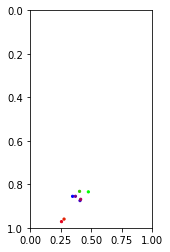

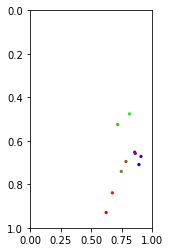

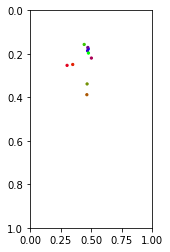

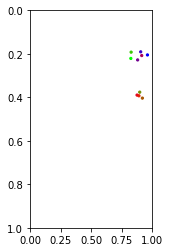

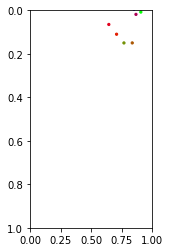

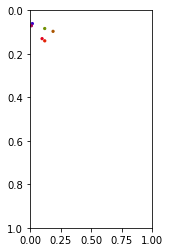

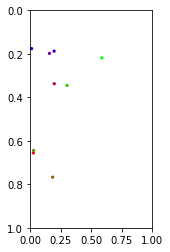

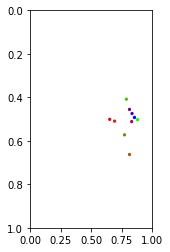

In [0]:
def print_20points_image(points):
  fig1, ax1 = plt.subplots()
  # we use one color for each point
  plt.scatter(points[:,0], points[:,1], s=5, c=[0,1,2,3,4,5,6,7,8,9], cmap="brg")
  ax1.set_aspect(16/9)
  plt.ylim([0,1])
  plt.xlim([0,1])
  plt.show()

to_print_data, to_print_target = generate_training_data(100, 1)
for x in to_print_data:
  print_20points_image(x)

And it doesn't look that good. I wouldn't be able to say what cursed parameters led to these bad results...

**But don't worry, these will make sure that on real life (where noise will be a real thing) it works.**

Now let's generate the real data.
Note that I'm using 1M projections but in the end, after being filtered to see if they got projected to the screen it will give me back 10% to 2% of this value, depending on the desired scale.

We also print mean and scale after fitting the data.
This should be used after inference to scale the data back to usable state.

In [0]:
from sklearn import preprocessing
num_samples = 1000*1000

data, target_raw = generate_training_data(num_samples, 2.0)
print(data.shape)   # (num_samples, num_vertices, 3): the vertices

scaler = preprocessing.StandardScaler().fit(target_raw)

print("mean:")
print(scaler.mean_)


print("scale:")
print(scaler.scale_)

target = scaler.transform(target_raw)
print(target.shape)  # (num_samples, 4+3): the quaternion and translation

data_test, target_test_raw = generate_training_data(int(num_samples / 4), 1.0)
target_test = scaler.transform(target_test_raw)
print(data_test.shape)   # (num_samples, num_vertices, 3): the vertices

(95463, 10, 2)
mean:
[-2.12522415e-03  2.64508744e-04 -1.33624768e-03  8.72294454e-01
  2.55325474e-02 -2.17989691e-01 -6.12684035e+01]
scale:
[ 0.27886152  0.27881693  0.28100003  0.06806152 20.15907429 20.19870753
 14.49564505]
(95463, 7)
(19219, 10, 2)


In [0]:
# This commented code is used to load an image and the image points of that image
# for debugging inside colab. Then this image and projection cloud be passed to
# print_20points_image_dbg and print_debug_image functions.

# import matplotlib.image as mpimg

# from google.colab import files

# uploaded = files.upload()

# console.log() the points in JS and paste them here, for instance...
# me_projected = np.array(
#   [[0.4185019950264415,0.5524818453609978],[0.4266780134780477,0.57556931891207],[0.4713510397070324,0.5780763383050266],[0.40269205065506064,0.5653979905737337],[0.6236172366960605,0.5153868185734058],[0.5496586340802241,0.5032626028513452],[0.39409408461629125,0.47401044973939377],[0.45162185420587186,0.48492150738404144],[0.501471723732045,0.6327295988488121],[0.36977609148491264,0.6067639717624883]]
# )

# me_photo = mpimg.imread('my_photo.png')


# lets create some functions that allow us to visualize the data that the NN gets
# and how it will become after being reprojected
def transform_points(target_points, quaternion_variable, translation_variable):
  x = quaternion.rotate(target_points,
                           quaternion_variable) + translation_variable


  return x

def print_20points_image_dbg(points, img=None):
  fig1, ax1 = plt.subplots()
  plt.scatter(points[:,0], points[:,1], s=5, c=[0,1,2,3,4,5,6,7,8,9], cmap="brg")
  ax1.set_aspect(16/9)
  if img != None:
    ax1.imshow(img, extent=[0, 1, 1, 0])
  plt.ylim([0,1])
  plt.xlim([0,1])
  plt.show()
# print_20points_image_dbg(_test_proj)

In [0]:
def rnd_img():
  while True:
    to_print_data, to_print_target = generate_training_data(100, 1)
    for x in to_print_data:
      return x

def print_debug_image(proj, img=None):
  res = model.predict(np.array([proj]))[0]
  den = scaler.inverse_transform(res)
  initial_orientation = transform_points(vertices, den[0:4],
                                       den[4:7]).numpy()


  reprojected = 1 - tfg.rendering.camera.perspective.project(
        initial_orientation,
        [1.0, 1.0],
        [0.5, 0.5],
    )
  print_20points_image_dbg(proj, img)
  print_20points_image_dbg(reprojected, img)


In [0]:
tf.keras.backend.set_floatx("float32")

# KISS :)
# Anything more complicated than this and overfitting happens.
model = keras.Sequential()
model.add(layers.Flatten(input_shape=(num_vertices, 2)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(7))

# We use 3D reprojection error
def pose_estimation_loss(y_true, y_pred):
  # y_true.shape : (batch, 7)
  y_true_q, y_true_tn = tf.split(y_true* scaler.scale_ + scaler.mean_, (4, 3), axis=-1)
  # y_pred.shape : (batch, 7)
  y_pred_q, y_pred_tn = tf.split(y_pred* scaler.scale_ + scaler.mean_, (4, 3), axis=-1)

  y_true_t = y_true_tn 
  y_pred_t = y_pred_tn 
  # vertices.shape: (num_vertices, 3)
  # corners.shape:(num_vertices, 1, 3)
  corners = tf.expand_dims(vertices, axis=1)

  # transformed_corners.shape: (num_vertices, batch, 3)
  # q and t shapes get pre-pre-padded with 1's following standard broadcast rules.
  transformed_corners = quaternion.rotate(corners, y_pred_q) + y_pred_t

  # recovered_corners.shape: (num_vertices, batch, 3)
  recovered_corners = quaternion.rotate(transformed_corners - y_true_t,
                                        quaternion.inverse(y_true_q))

  # vertex_error.shape: (num_vertices, batch)

  # I found that by using the abs error will prevent the NN from underestimating
  # the scale of the images (on real life).
  vertex_error = tf.reduce_sum(tf.math.abs(recovered_corners - corners), axis=-1)
  # vertex_error = tf.reduce_sum((recovered_corners - corners)**2, axis=-1)

  return tf.reduce_mean(vertex_error)

model.compile(loss=pose_estimation_loss,
              metrics=["mae","mse"],
              optimizer="adam"
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 455       
Total params: 5,959
Trainable params: 5,959
Non-trainable params: 0
_________________________________________________________________


# Training

At this point, everything is in place to start training the neural network!

In [0]:
# Callback allowing to display the progression of the training task.
class ProgressTracker(keras.callbacks.Callback):

  def __init__(self, num_epochs, step=5):
    self.num_epochs = num_epochs
    self.current_epoch = 0.
    self.step = step
    self.last_percentage_report = 0

  def on_epoch_end(self, batch, logs={}):
    print_debug_image(rnd_img())
    self.current_epoch += 1.
    training_percentage = int(self.current_epoch * 100.0 / self.num_epochs)
    if training_percentage - self.last_percentage_report >= self.step:
      print('Training ' + str(
          training_percentage) + '% complete. Training loss: ' + str(
              logs.get('loss')) + ' | Validation loss: ' + str(
                  logs.get('val_loss')))
      self.last_percentage_report = training_percentage

Train on 95463 samples, validate on 19219 samples
Epoch 1/50


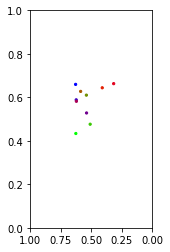

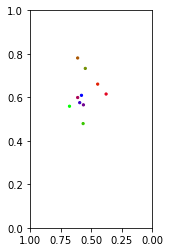

95463/95463 - 21s - loss: 14.7991 - mae: 0.5945 - mse: 0.6571 - val_loss: 10.8370 - val_mae: 0.4945 - val_mse: 0.5198
Epoch 2/50


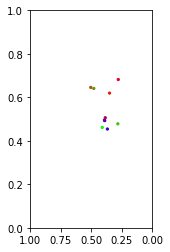

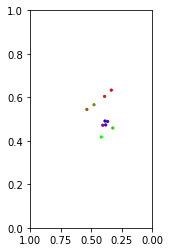

95463/95463 - 20s - loss: 9.8161 - mae: 0.4756 - mse: 0.4751 - val_loss: 8.8762 - val_mae: 0.4402 - val_mse: 0.4255
Epoch 3/50


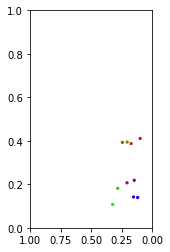

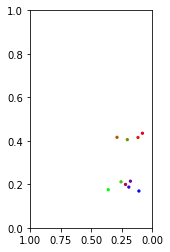

Training 6% complete. Training loss: 8.218956067967872 | Validation loss: 5.956337847219148
95463/95463 - 20s - loss: 8.2190 - mae: 0.4163 - mse: 0.3804 - val_loss: 5.9563 - val_mae: 0.3460 - val_mse: 0.2897
Epoch 4/50


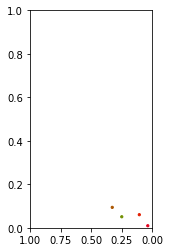

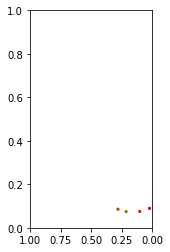

95463/95463 - 20s - loss: 7.3017 - mae: 0.3514 - mse: 0.2788 - val_loss: 5.1102 - val_mae: 0.2896 - val_mse: 0.2063
Epoch 5/50


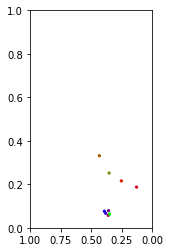

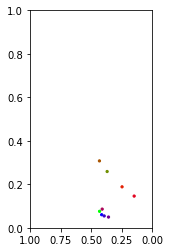

95463/95463 - 20s - loss: 6.8803 - mae: 0.3083 - mse: 0.2188 - val_loss: 4.8018 - val_mae: 0.2636 - val_mse: 0.1709
Epoch 6/50


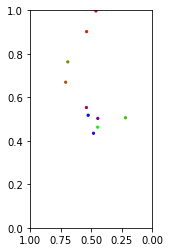

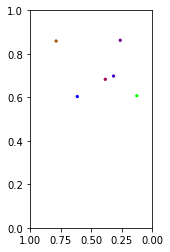

Training 12% complete. Training loss: 6.666085966959838 | Validation loss: 4.647078591384503
95463/95463 - 20s - loss: 6.6661 - mae: 0.2836 - mse: 0.1862 - val_loss: 4.6471 - val_mae: 0.2528 - val_mse: 0.1581
Epoch 7/50


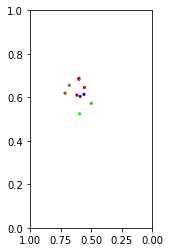

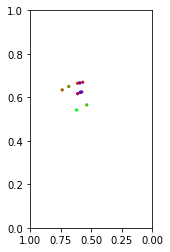

95463/95463 - 20s - loss: 6.4965 - mae: 0.2689 - mse: 0.1678 - val_loss: 4.9039 - val_mae: 0.2514 - val_mse: 0.1522
Epoch 8/50


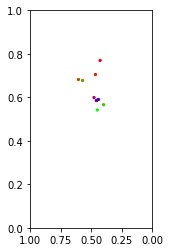

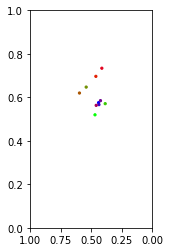

95463/95463 - 20s - loss: 6.3689 - mae: 0.2592 - mse: 0.1559 - val_loss: 4.4932 - val_mae: 0.2445 - val_mse: 0.1444
Epoch 9/50


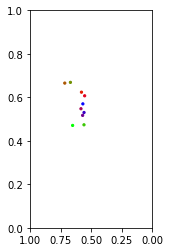

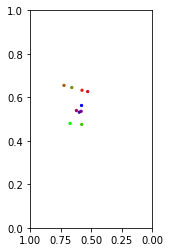

Training 18% complete. Training loss: 6.282613616560463 | Validation loss: 4.364968635033691
95463/95463 - 20s - loss: 6.2826 - mae: 0.2520 - mse: 0.1475 - val_loss: 4.3650 - val_mae: 0.2416 - val_mse: 0.1407
Epoch 10/50


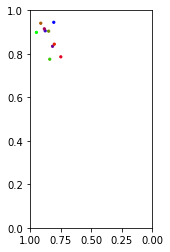

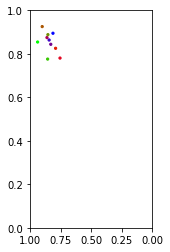

95463/95463 - 20s - loss: 6.1742 - mae: 0.2463 - mse: 0.1410 - val_loss: 4.4754 - val_mae: 0.2380 - val_mse: 0.1350
Epoch 11/50


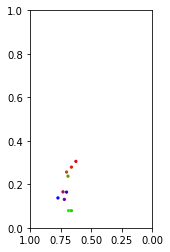

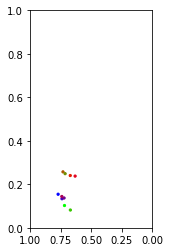

95463/95463 - 20s - loss: 6.1574 - mae: 0.2431 - mse: 0.1375 - val_loss: 4.8426 - val_mae: 0.2392 - val_mse: 0.1332
Epoch 12/50


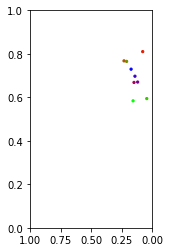

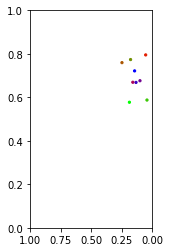

Training 24% complete. Training loss: 6.052393034284879 | Validation loss: 4.227685907305239
95463/95463 - 20s - loss: 6.0524 - mae: 0.2376 - mse: 0.1314 - val_loss: 4.2277 - val_mae: 0.2397 - val_mse: 0.1387
Epoch 13/50


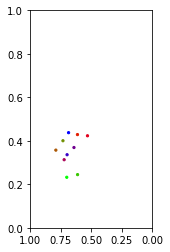

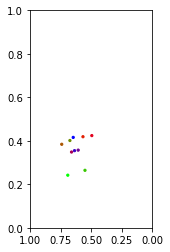

95463/95463 - 20s - loss: 5.9906 - mae: 0.2368 - mse: 0.1303 - val_loss: 3.9750 - val_mae: 0.2292 - val_mse: 0.1286
Epoch 14/50


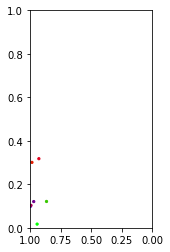

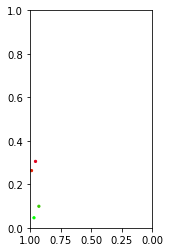

95463/95463 - 20s - loss: 5.9518 - mae: 0.2331 - mse: 0.1265 - val_loss: 3.8449 - val_mae: 0.2254 - val_mse: 0.1240
Epoch 15/50


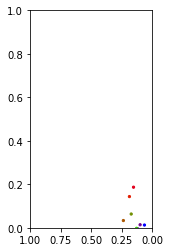

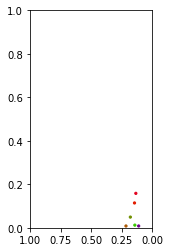

Training 30% complete. Training loss: 5.899296703131631 | Validation loss: 3.911634272880004
95463/95463 - 20s - loss: 5.8993 - mae: 0.2322 - mse: 0.1257 - val_loss: 3.9116 - val_mae: 0.2240 - val_mse: 0.1207
Epoch 16/50


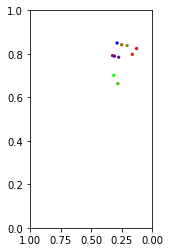

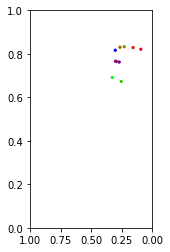

95463/95463 - 20s - loss: 5.8881 - mae: 0.2294 - mse: 0.1226 - val_loss: 3.9485 - val_mae: 0.2217 - val_mse: 0.1197
Epoch 17/50


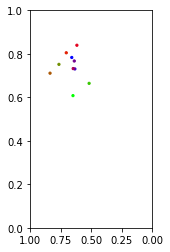

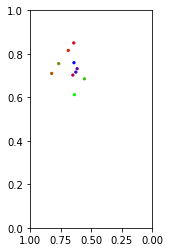

95463/95463 - 20s - loss: 5.8261 - mae: 0.2264 - mse: 0.1193 - val_loss: 4.2541 - val_mae: 0.2223 - val_mse: 0.1215
Epoch 18/50


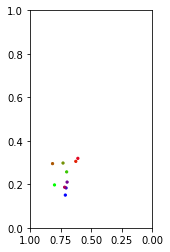

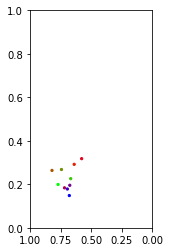

Training 36% complete. Training loss: 5.7587019785923825 | Validation loss: 3.9214827427476284
95463/95463 - 20s - loss: 5.7587 - mae: 0.2254 - mse: 0.1191 - val_loss: 3.9215 - val_mae: 0.2215 - val_mse: 0.1227
Epoch 19/50


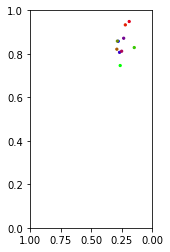

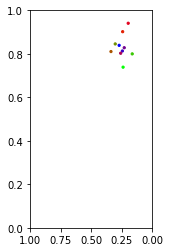

95463/95463 - 20s - loss: 5.7752 - mae: 0.2239 - mse: 0.1178 - val_loss: 3.8624 - val_mae: 0.2161 - val_mse: 0.1192
Epoch 20/50


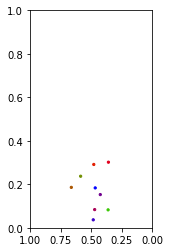

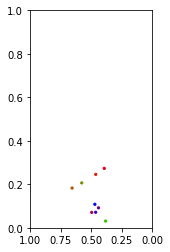

95463/95463 - 20s - loss: 5.7241 - mae: 0.2234 - mse: 0.1181 - val_loss: 3.8597 - val_mae: 0.2219 - val_mse: 0.1259
Epoch 21/50


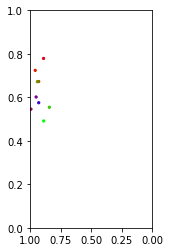

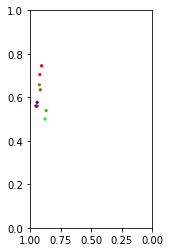

Training 42% complete. Training loss: 5.701867341493243 | Validation loss: 4.754604290027798
95463/95463 - 20s - loss: 5.7019 - mae: 0.2218 - mse: 0.1161 - val_loss: 4.7546 - val_mae: 0.2281 - val_mse: 0.1264
Epoch 22/50


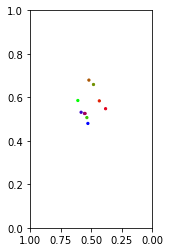

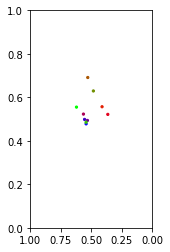

95463/95463 - 20s - loss: 5.6963 - mae: 0.2215 - mse: 0.1164 - val_loss: 3.7448 - val_mae: 0.2222 - val_mse: 0.1275
Epoch 23/50


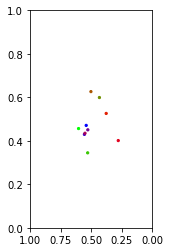

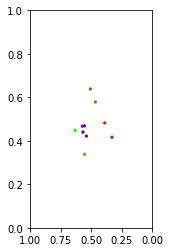

95463/95463 - 20s - loss: 5.6602 - mae: 0.2205 - mse: 0.1153 - val_loss: 3.8418 - val_mae: 0.2183 - val_mse: 0.1250
Epoch 24/50


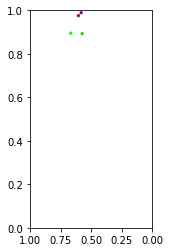

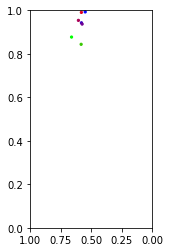

Training 48% complete. Training loss: 5.619853844395437 | Validation loss: 4.177428263234474
95463/95463 - 20s - loss: 5.6199 - mae: 0.2192 - mse: 0.1141 - val_loss: 4.1774 - val_mae: 0.2173 - val_mse: 0.1219
Epoch 25/50


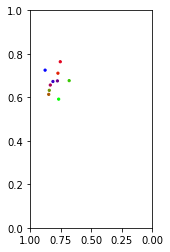

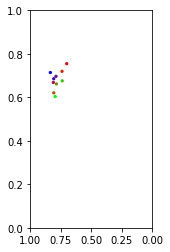

95463/95463 - 20s - loss: 5.6283 - mae: 0.2186 - mse: 0.1137 - val_loss: 4.1333 - val_mae: 0.2173 - val_mse: 0.1232
Epoch 26/50


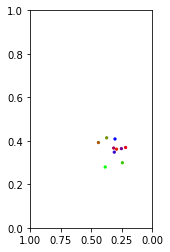

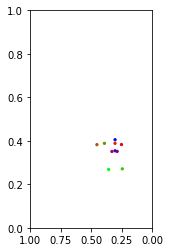

95463/95463 - 20s - loss: 5.6090 - mae: 0.2158 - mse: 0.1108 - val_loss: 3.7139 - val_mae: 0.2116 - val_mse: 0.1198
Epoch 27/50


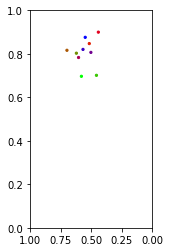

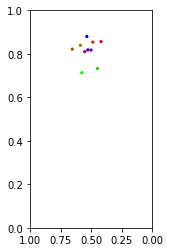

Training 54% complete. Training loss: 5.540772255117633 | Validation loss: 3.8702772038927855
95463/95463 - 20s - loss: 5.5408 - mae: 0.2151 - mse: 0.1100 - val_loss: 3.8703 - val_mae: 0.2137 - val_mse: 0.1194
Epoch 28/50


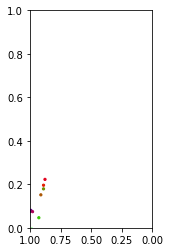

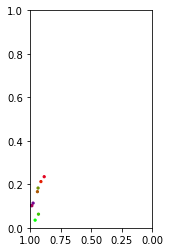

95463/95463 - 20s - loss: 5.5806 - mae: 0.2141 - mse: 0.1088 - val_loss: 3.7650 - val_mae: 0.2141 - val_mse: 0.1196
Epoch 29/50


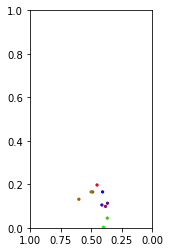

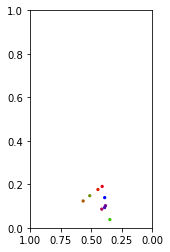

95463/95463 - 20s - loss: 5.5331 - mae: 0.2122 - mse: 0.1067 - val_loss: 3.7488 - val_mae: 0.2173 - val_mse: 0.1216
Epoch 30/50


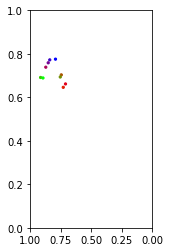

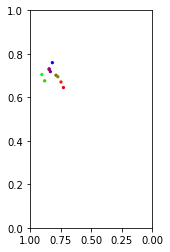

Training 60% complete. Training loss: 5.512782689458948 | Validation loss: 4.017307977732464
95463/95463 - 20s - loss: 5.5128 - mae: 0.2113 - mse: 0.1060 - val_loss: 4.0173 - val_mae: 0.2124 - val_mse: 0.1152
Epoch 31/50


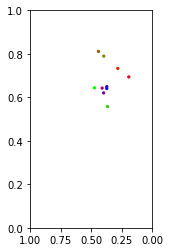

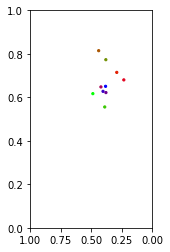

95463/95463 - 20s - loss: 5.4847 - mae: 0.2096 - mse: 0.1041 - val_loss: 3.6371 - val_mae: 0.2129 - val_mse: 0.1207
Epoch 32/50


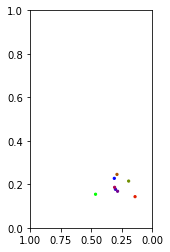

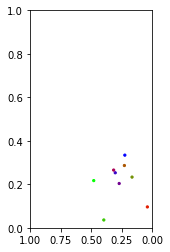

95463/95463 - 20s - loss: 5.4761 - mae: 0.2084 - mse: 0.1029 - val_loss: 3.7970 - val_mae: 0.2103 - val_mse: 0.1166
Epoch 33/50


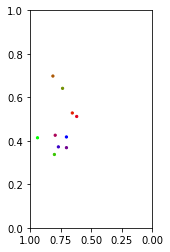

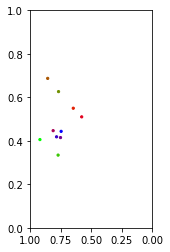

Training 66% complete. Training loss: 5.488950231194343 | Validation loss: 3.6992443035244227
95463/95463 - 20s - loss: 5.4890 - mae: 0.2072 - mse: 0.1017 - val_loss: 3.6992 - val_mae: 0.2103 - val_mse: 0.1192
Epoch 34/50


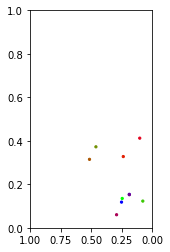

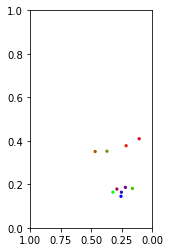

95463/95463 - 20s - loss: 5.4682 - mae: 0.2064 - mse: 0.1003 - val_loss: 3.8262 - val_mae: 0.2061 - val_mse: 0.1138
Epoch 35/50


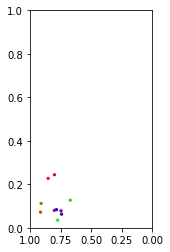

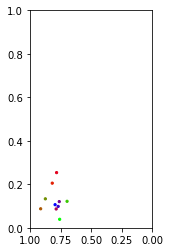

95463/95463 - 20s - loss: 5.4738 - mae: 0.2059 - mse: 0.1000 - val_loss: 4.1729 - val_mae: 0.2073 - val_mse: 0.1105
Epoch 36/50


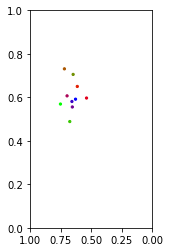

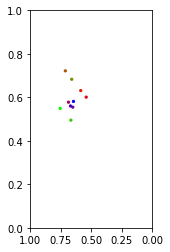

Training 72% complete. Training loss: 5.458342419982539 | Validation loss: 3.9890736849537887
95463/95463 - 20s - loss: 5.4583 - mae: 0.2052 - mse: 0.0994 - val_loss: 3.9891 - val_mae: 0.2071 - val_mse: 0.1141
Epoch 37/50


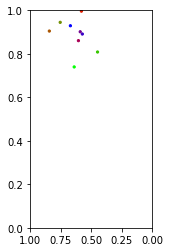

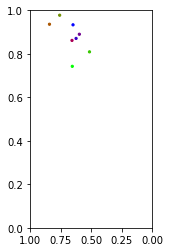

95463/95463 - 20s - loss: 5.4400 - mae: 0.2033 - mse: 0.0970 - val_loss: 3.8052 - val_mae: 0.2050 - val_mse: 0.1107
Epoch 38/50


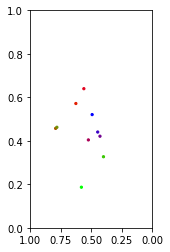

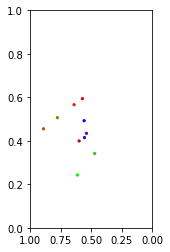

95463/95463 - 19s - loss: 5.4206 - mae: 0.2022 - mse: 0.0964 - val_loss: 3.9740 - val_mae: 0.2080 - val_mse: 0.1152
Epoch 39/50


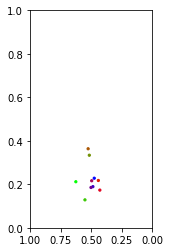

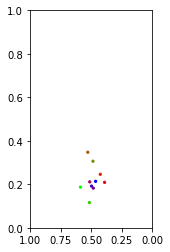

Training 78% complete. Training loss: 5.376764404792818 | Validation loss: 3.9932028915440605
95463/95463 - 20s - loss: 5.3768 - mae: 0.2004 - mse: 0.0946 - val_loss: 3.9932 - val_mae: 0.2027 - val_mse: 0.1075
Epoch 40/50


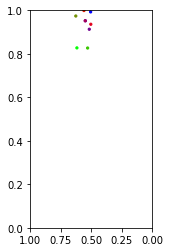

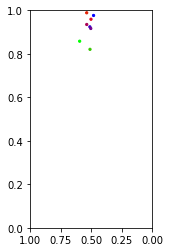

95463/95463 - 20s - loss: 5.4206 - mae: 0.2003 - mse: 0.0937 - val_loss: 3.8583 - val_mae: 0.1999 - val_mse: 0.1053
Epoch 41/50


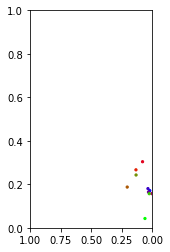

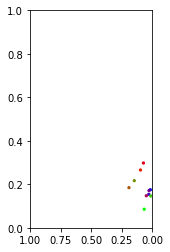

95463/95463 - 20s - loss: 5.3985 - mae: 0.1997 - mse: 0.0934 - val_loss: 4.1700 - val_mae: 0.2019 - val_mse: 0.1070
Epoch 42/50


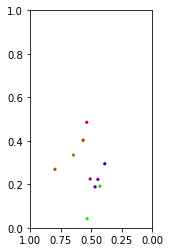

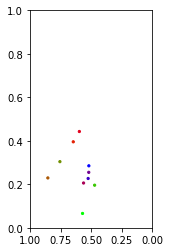

Training 84% complete. Training loss: 5.3524702685738665 | Validation loss: 3.8570633685342592
95463/95463 - 20s - loss: 5.3525 - mae: 0.1985 - mse: 0.0926 - val_loss: 3.8571 - val_mae: 0.1999 - val_mse: 0.1066
Epoch 43/50


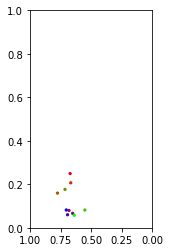

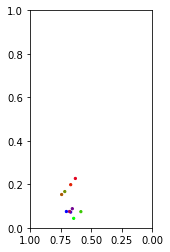

95463/95463 - 20s - loss: 5.3724 - mae: 0.1984 - mse: 0.0921 - val_loss: 4.5103 - val_mae: 0.2041 - val_mse: 0.1084
Epoch 44/50


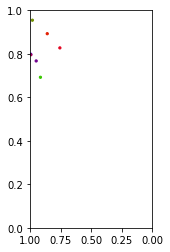

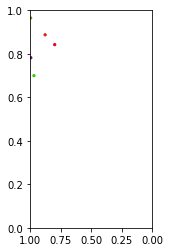

95463/95463 - 20s - loss: 5.3677 - mae: 0.1973 - mse: 0.0908 - val_loss: 3.5932 - val_mae: 0.2000 - val_mse: 0.1077
Epoch 45/50


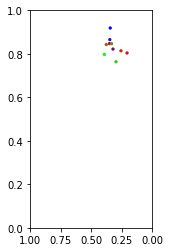

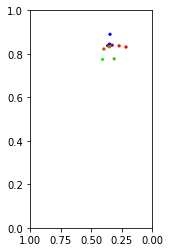

Training 90% complete. Training loss: 5.354351130309381 | Validation loss: 4.19373440460891
95463/95463 - 20s - loss: 5.3544 - mae: 0.1964 - mse: 0.0904 - val_loss: 4.1937 - val_mae: 0.1993 - val_mse: 0.1041
Epoch 46/50


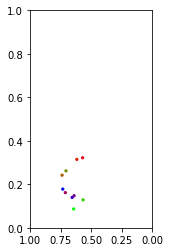

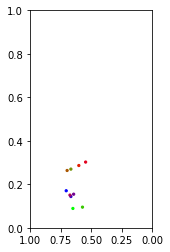

95463/95463 - 19s - loss: 5.3342 - mae: 0.1950 - mse: 0.0889 - val_loss: 3.6982 - val_mae: 0.2048 - val_mse: 0.1100
Epoch 47/50


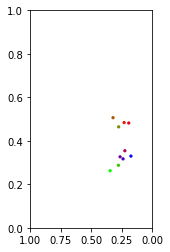

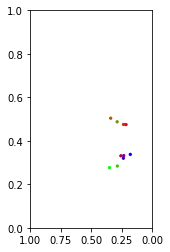

95463/95463 - 20s - loss: 5.3617 - mae: 0.1950 - mse: 0.0887 - val_loss: 3.6335 - val_mae: 0.1946 - val_mse: 0.1015
Epoch 48/50


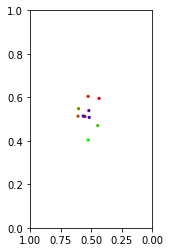

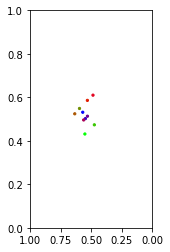

Training 96% complete. Training loss: 5.346473395911221 | Validation loss: 4.2307463519946245
95463/95463 - 20s - loss: 5.3465 - mae: 0.1951 - mse: 0.0887 - val_loss: 4.2307 - val_mae: 0.1989 - val_mse: 0.1024
Epoch 49/50


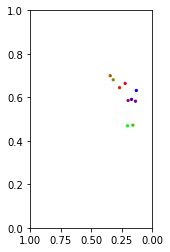

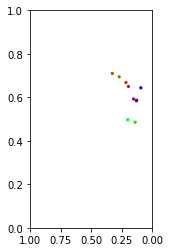

95463/95463 - 20s - loss: 5.3464 - mae: 0.1939 - mse: 0.0876 - val_loss: 3.6026 - val_mae: 0.1982 - val_mse: 0.1053
Epoch 50/50


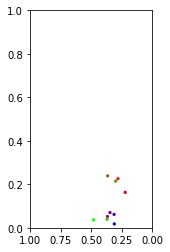

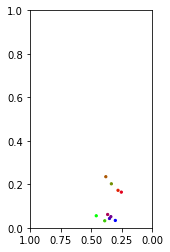

95463/95463 - 20s - loss: 5.3666 - mae: 0.1933 - mse: 0.0868 - val_loss: 3.6058 - val_mae: 0.1941 - val_mse: 0.0997


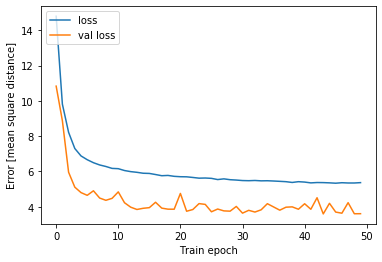

In [0]:
import tensorflow as tf
import datetime, os

# tensorabord callbacks
logdir = os.path.join("logs3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# uncomment this to start tensorboard now (before training, if you want)
# %tensorboard --logdir logs3

# Everything is now in place to train.
EPOCHS = 50
pt = ProgressTracker(EPOCHS)


history = model.fit(
    data,
    target,
    epochs=EPOCHS,
    validation_data=(data_test, target_test),
    verbose=2,
    callbacks=[tensorboard_callback, pt]

    )

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val loss'], loc='upper left')
plt.xlabel('Train epoch')
_ = plt.ylabel('Error [mean square distance]')

In [0]:
model.save('model.h5')    
model.save_weights('model_weights.h5')

# save it, convert it to "js" and test on yourself :)